In [1]:
import pandas as pd

# Path to csv file
data_path = "C:\\Users\\S1157\\OneDrive\\Documents\\実装6.20\\データセット\\mis_information.csv"
# Load the file into a pandas DataFrame work
df = pd.read_csv(data_path)

#Display the structure and contents of the DataFrame
print(df.head())

              id                                               text  label
0     BBCDanielS  Charlie Hebdo became well known for publishing...    0.0
1      robbylevy  Now 10 dead in a shooting there today RT "@BBC...    0.0
2  ModerateInAll  @BBCDanielS @BBCWorld I'm guessing this is bei...    0.0
3    GabTarquini  @BBCDanielS @BBCWorld why would you mention th...    0.0
4  freethought41            @BBCDanielS @BBCWorld perps identified?    0.0


In [2]:

texts = df['text'].tolist()
if df['label'].isnull().any():
    df['label'].fillna(0, inplace=True)  # Replace NaN with 0 or any appropriate value

df['label'] = df['label'].replace([float('inf'), float('-inf')], 0)  # Replace inf with 0 or any appropriate value

# Convert labels to binary integers (0 and 1)
labels = df['label'].round().astype(int)
labels = labels.tolist()

In [3]:
from sklearn.model_selection import train_test_split
# Split the data into training and validation sets (e.g., 80% training, 20% validation)
train_texts, val_texts, train_labels, val_labels = train_test_split(texts, labels, test_size=0.2, random_state=42)


In [4]:
print(train_labels)

[1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 

In [5]:
batch_size = 32
learning_rate = 2e-5
num_epochs = 5
warmup_proportion = 0.1


In [6]:
import torch 
from transformers import DebertaForSequenceClassification, DebertaTokenizer, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from sklearn.metrics import accuracy_score, classification_report

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.backends.cudnn.enabled = False
# Load tokenizer and model
tokenizer = DebertaTokenizer.from_pretrained('microsoft/deberta-base')
model = DebertaForSequenceClassification.from_pretrained('microsoft/deberta-base', num_labels=2)
model.to(device)


# Tokenize training data
train_encodings = tokenizer(
    train_texts,
    padding='max_length',  # Pad to max_length
    truncation=True,
    max_length=100,  # Set max_length to match average length
    return_tensors="pt")

# Tokenize test data
val_encodings = tokenizer(
    val_texts,
    padding='max_length',  # Pad to max_length
    truncation=True,
    max_length=100,  # Set max_length to match average length
    return_tensors="pt")

train_labels = torch.tensor(train_labels)
val_labels = torch.tensor(val_labels)

# Prepare dataset and dataloader
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Instantiate CustomDataset with tokenized inputs and labels
train_dataset = CustomDataset(train_encodings, train_labels)
val_dataset = CustomDataset(val_encodings, val_labels)


c:\Users\S1157\anaconda3\Lib\site-packages\huggingface_hub-0.23.0-py3.8.egg\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
# Define DataLoader for training dataset
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

optimizer = AdamW(model.parameters(), lr=learning_rate)

# Set up optimizer and scheduler
total_steps = len(train_loader) * num_epochs  # Total number of training steps
warmup_steps = int(total_steps * warmup_proportion)  # Number of warmup steps

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps)

train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []

for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_epoch_loss = 0.0
    train_correct_predictions = 0
    train_total_predictions = 0

    for batch in train_loader:
        optimizer.zero_grad()
        inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
        labels = batch['labels'].to(device)

        labels = labels.long()
        outputs = model(**inputs)
        logits = outputs.logits

        loss = torch.nn.functional.cross_entropy(logits, labels)  # Cross-entropy loss
        loss.backward()
        optimizer.step()
        scheduler.step()

        train_epoch_loss += loss.item()
        preds = torch.argmax(logits, dim=1)
        train_correct_predictions += torch.sum(preds == labels).item()
        train_total_predictions += len(labels)

    train_loss = train_epoch_loss / len(train_loader)
    train_accuracy = train_correct_predictions / train_total_predictions
    train_loss_list.append(train_loss)
    train_acc_list.append(train_accuracy)

    # Validation phase
    model.eval()
    val_epoch_loss = 0.0
    val_correct_predictions = 0
    val_total_predictions = 0

    with torch.no_grad():
        for batch in val_loader:
            inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
            labels = batch['labels'].to(device)
            labels = labels.long()  # Ensure labels are of type torch.long

            outputs = model(**inputs)
            logits = outputs.logits
            logits = logits.float()  # Ensure logits are of type torch.float if necessary

            # Compute cross-entropy loss
            val_loss = torch.nn.functional.cross_entropy(logits, labels)

            val_epoch_loss += val_loss.item()
            val_preds = torch.argmax(logits, dim=1)
            val_correct_predictions += torch.sum(val_preds == labels).item()
            val_total_predictions += len(labels)

     # Calculate average validation loss and accuracy
    val_loss = val_epoch_loss / len(val_loader)
    val_accuracy = val_correct_predictions / val_total_predictions


    print(f"Epoch [{epoch + 1}/{num_epochs}], "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")
    
    # Save the trained model and tokenizer
output_dir = "C:\\Users\\S1157\\OneDrive\\Documents\\実装6.20\\モデル"
model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)
print(f"Model and tokenizer saved to: {output_dir}")


c:\Users\S1157\anaconda3\Lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
C:\Users\S1157\AppData\Local\Temp\ipykernel_29160\2800038429.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
C:\Users\S1157\AppData\Local\Temp\ipykernel_29160\2800038429.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx])


Epoch [1/5], Train Loss: 0.3981, Train Acc: 0.8140, Val Loss: 0.2653, Val Acc: 0.8909
Epoch [2/5], Train Loss: 0.2155, Train Acc: 0.9093, Val Loss: 0.2095, Val Acc: 0.9125
Epoch [3/5], Train Loss: 0.1447, Train Acc: 0.9380, Val Loss: 0.2032, Val Acc: 0.9170
Epoch [4/5], Train Loss: 0.1023, Train Acc: 0.9558, Val Loss: 0.2021, Val Acc: 0.9233
Epoch [5/5], Train Loss: 0.0727, Train Acc: 0.9686, Val Loss: 0.2316, Val Acc: 0.9247
Model and tokenizer saved to: C:\Users\S1157\OneDrive\Documents\実装6.20\モデル


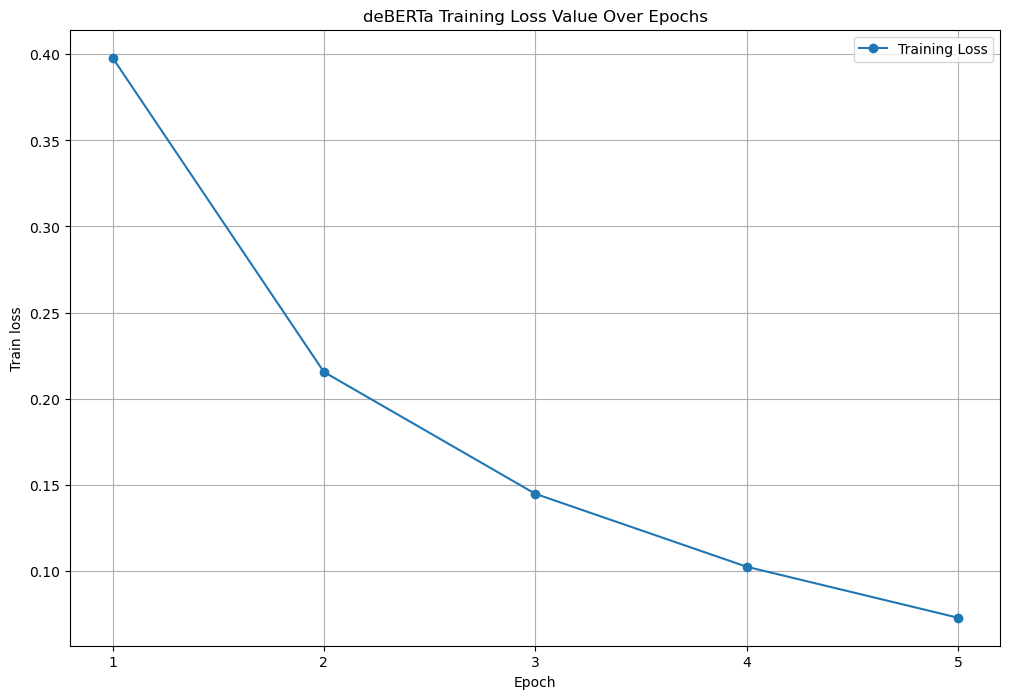

In [8]:
import matplotlib.pyplot as plt
# Plotting the training progress
plt.figure(figsize=(12, 8))
plt.plot(range(1, num_epochs + 1), train_loss_list, label='Training Loss', marker='o')
#plt.plot(range(1, num_epochs + 1), val_loss_list, label='Validation Loss', marker='o')
#plt.plot(range(1, num_epochs + 1), train_acc_list, label='Training Accuracy', marker='o')
#plt.plot(range(1, num_epochs + 1), val_acc_list, label='Validation Accuracy', marker='o')
plt.title('deBERTa Training Loss Value Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Train loss')
plt.xticks(range(1, num_epochs + 1))
plt.legend()
plt.grid(True)
plt.show()

In [9]:
val_acc_list_self = {0.8909, 0.9125, 0.9170, 0.9233, 0.9247}
print(val_acc_list_self)


{0.8909, 0.9125, 0.917, 0.9233, 0.9247}


In [10]:

print(train_acc_list)

[0.8140105288346494, 0.9093084469968892, 0.9379636276621202, 0.9557908590571907, 0.9685530828746909]


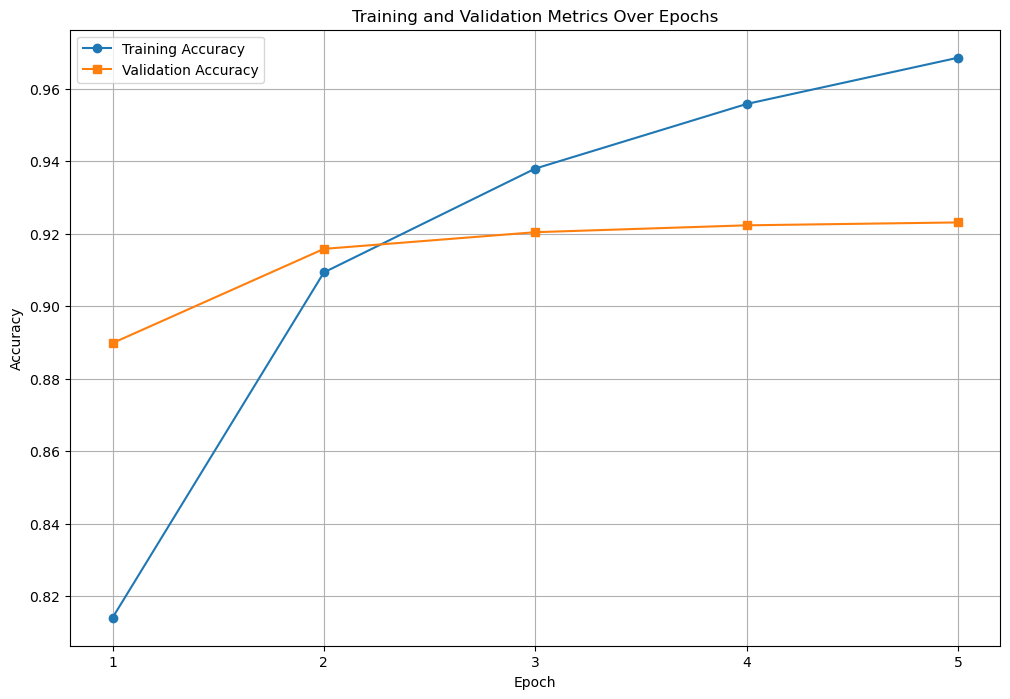

In [11]:
num_epochs = len(train_acc_list)  # Assuming train_acc_list is defined elsewhere

val_acc_list_self = [0.8898, 0.9158, 0.9204, 0.9223, 0.9231]  # Example data

# Check the length of val_acc_list_self
assert len(val_acc_list_self) == num_epochs, "deBERTa Validation accuracy list length does not match num_epochs"

# Plotting the training and validation accuracy over epochs
plt.figure(figsize=(12, 8))
plt.plot(range(1, num_epochs + 1), train_acc_list, label='Training Accuracy', marker='o')
plt.plot(range(1, num_epochs + 1), val_acc_list_self, label='Validation Accuracy', marker='s')
plt.title('Training and Validation Metrics Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(range(1, num_epochs + 1))
plt.legend()
plt.grid(True)
plt.show()

In [12]:
with torch.no_grad():
    all_preds = []
    all_labels = []
    for batch in val_loader:
        inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
        labels = batch['labels'].to(device)
        outputs = model(**inputs)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1).tolist()
        all_preds.extend(preds)
        all_labels.extend(labels.tolist())


C:\Users\S1157\AppData\Local\Temp\ipykernel_29160\2800038429.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
C:\Users\S1157\AppData\Local\Temp\ipykernel_29160\2800038429.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx])


In [13]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

valid_indices = ~np.isnan(all_labels)
all_labels = np.array(all_labels)[valid_indices]
all_preds = np.array(all_preds)[valid_indices]

# Compute and print classification report and confusion matrix
print(classification_report(all_labels, all_preds))
print(confusion_matrix(all_labels, all_preds))

              precision    recall  f1-score   support

           0       0.94      0.96      0.95      9752
           1       0.85      0.80      0.83      2785

    accuracy                           0.92     12537
   macro avg       0.90      0.88      0.89     12537
weighted avg       0.92      0.92      0.92     12537

[[9364  388]
 [ 556 2229]]


In [14]:
from transformers import DebertaForSequenceClassification, DebertaTokenizer
model_path = "C:\\Users\\S1157\\OneDrive\\Documents\\実装6.20\\モデル\\deBERTa"
# Load the tokenizer and model
tokenizer = DebertaTokenizer.from_pretrained(model_path)
model = DebertaForSequenceClassification.from_pretrained(model_path)

In [15]:
model.eval

<bound method Module.eval of DebertaForSequenceClassification(
  (deberta): DebertaModel(
    (embeddings): DebertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=0)
      (LayerNorm): DebertaLayerNorm()
      (dropout): StableDropout()
    )
    (encoder): DebertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x DebertaLayer(
          (attention): DebertaAttention(
            (self): DisentangledSelfAttention(
              (in_proj): Linear(in_features=768, out_features=2304, bias=False)
              (pos_dropout): StableDropout()
              (pos_proj): Linear(in_features=768, out_features=768, bias=False)
              (pos_q_proj): Linear(in_features=768, out_features=768, bias=True)
              (dropout): StableDropout()
            )
            (output): DebertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): DebertaLayerNorm()
              (dropout): StableDropout()
        

In [16]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params}")

Total parameters: 139193858


In [16]:
import pandas as pd
import torch
from transformers import DebertaTokenizer, DebertaForSequenceClassification
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Load the CSV file
file_path = 'C:\\Users\\S1157\\OneDrive\\Documents\\implementation6.20\\Twitter API\\tweets_threat.csv'
df = pd.read_csv(file_path)

In [17]:
df

,User,Date Created,Number of Likes,Source of Tweet,Tweet
0,1766117659941212160,2024-08-12 06:34:31+00:00,0,NaN,As COVID-19 cases emerge during the Paris 2024...
1,1612013910575521793,2024-08-12 06:24:52+00:00,0,NaN,Did the Opening Ceremony of the Paris Olympics...
2,14437914,2024-08-12 06:02:00+00:00,33,NaN,"In the lead-up to the Olympics, French authori..."
3,2835317718,2024-08-12 05:55:24+00:00,9809,NaN,Security Arrangements at Paris Olympics 🗼 http...
4,715095151442599936,2024-08-12 05:54:11+00:00,81,NaN,The French/allied intel and security agencies ...
...,...,...,...,...,...
2958,357326131,2024-08-12 03:44:40+00:00,2,NaN,@RissaU95 That was someone who didn't like me ...
2959,1366815999207604225,2024-08-12 03:43:32+00:00,0,NaN,@BowesChay Now is time for putin to show convi...
2960,1038379759674187776,2024-08-12 03:41:09+00:00,0,NaN,@HeatleandAiden Salty bitter American fanboy😂 ...
2961,1418915493596078080,2024-08-12 03:40:57+00:00,1,NaN,"@BarcaWorldwide He had 16 G/A in 31 games, mor..."


In [18]:
model_path = "C:\\Users\\S1157\\OneDrive\\Documents\\implementation6.20\\model\\deBERTa"
# Load the tokenizer and model
tokenizer = DebertaTokenizer.from_pretrained(model_path)
model = DebertaForSequenceClassification.from_pretrained(model_path)
model.to(device)

DebertaForSequenceClassification(
  (deberta): DebertaModel(
    (embeddings): DebertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=0)
      (LayerNorm): DebertaLayerNorm()
      (dropout): StableDropout()
    )
    (encoder): DebertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x DebertaLayer(
          (attention): DebertaAttention(
            (self): DisentangledSelfAttention(
              (in_proj): Linear(in_features=768, out_features=2304, bias=False)
              (pos_dropout): StableDropout()
              (pos_proj): Linear(in_features=768, out_features=768, bias=False)
              (pos_q_proj): Linear(in_features=768, out_features=768, bias=True)
              (dropout): StableDropout()
            )
            (output): DebertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): DebertaLayerNorm()
              (dropout): StableDropout()
            )
          )
          (

In [19]:
texts = df['Tweet'].tolist()  # Adjust the column name as needed
batch_size = 16  # Adjust this based on available GPU memory

# Placeholder for predictions
predictions = []

# Process in batches to avoid OOM errors
for i in range(0, len(texts), batch_size):
    batch_texts = texts[i:i + batch_size]
    inputs = tokenizer(batch_texts, padding=True, truncation=True, return_tensors="pt")
    inputs = {key: value.to(device) for key, value in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        batch_predictions = torch.argmax(logits, dim=1).cpu().numpy()
        predictions.extend(batch_predictions)

    # Clear memory
    del inputs, outputs, logits, batch_predictions
    torch.cuda.empty_cache()

# Add the predictions as a new column to the dataframe
df['prediction'] = predictions  # 1 for rumor, 0 for not rumor

# Save the updated dataframe to a new CSV file
output_file_path = 'C:\\Users\\S1157\\OneDrive\\Documents\\implementation6.20\\Twitter API\\predicted\\tweets_threat_pre.csv'
df.to_csv(output_file_path, index=False)

print(f"Predictions saved to {output_file_path}")

Predictions saved to C:\Users\S1157\OneDrive\Documents\implementation6.20\Twitter API\predicted\tweets_threat_pre.csv
